In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import logging
from math import ceil
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


Load dataset

In [4]:
data = pd.read_csv("/Users/avinashkaur/Desktop/emorec/fer2013/fer2013.csv")

Know your dataset

In [5]:
data.shape

(35887, 3)

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Let's find out what else is there in the 'Usage' column

In [7]:
np.unique(data["Usage"].values.ravel())

array(['PrivateTest', 'PublicTest', 'Training'], dtype=object)

Number of images in the training dataset therefore is: 

In [8]:
print(len(data[(data.Usage)=="Training"]))

28709


In [9]:
train_data = data[data.Usage == "Training"]

In [107]:
pixels_values = train_data.pixels.str.split(" ").tolist()

Making it a dataframe for ease of computation

In [109]:
pixels_values = pd.DataFrame(pixels_values, dtype=int)

In [110]:
images = pixels_values.values

In [111]:
images = images.astype(np.float)

In [73]:
images.shape

(28709, 2304)

In [112]:
#Define a function to show image through 48*48 pixels
import matplotlib.image as mpimg
def show(img):
    show_image = img.reshape(48,48)
    imgplot = plt.imshow(show_image, cmap = 'gray')
    plt.show()

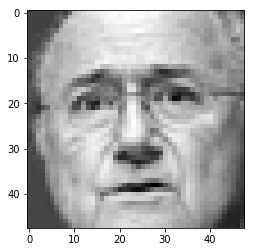

In [113]:
#show one image
show(images[5])

Per image normalization is carried out (Across the columns)

In [87]:
images = images - images.mean(axis=1).reshape(-1,1)

Scaling so that they remain in similar ranges. This ensures that our gradients don't go out of control.

In [88]:
images = np.multiply(images,100.0/255.0)

We take mean of every pixel i.e. mean across the rows of the images array

In [117]:
each_pixel_mean = images.mean(axis=0)

In [118]:
each_pixel_std = np.std(images, axis=0)

Normalizing the overall image array

In [91]:
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)

In [99]:
images.shape

(28709, 2304)

In [120]:
image_pixels = images.shape[1]
print('Flat pixel values is %d'%(image_pixels))

Flat pixel values is 2304


In [121]:
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)

In [122]:
image_width

48

In [123]:
labels_flat = train_data["emotion"].values.ravel()

In [124]:
labels_count = np.unique(labels_flat).shape[0]

In [125]:
print('The number of different facial expressions is %d'%labels_count)

The number of different facial expressions is 7


In [126]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [127]:
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [128]:
labels[0]

array([1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [149]:
# split data into training & validation
print("Total images: ", len(images))
VALIDATION_SIZE = 1709
print("Images in the validation set:", VALIDATION_SIZE)

Total images:  28709
Images in the validation set: 1709


In [150]:
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

Final Training data therefore is:

In [151]:
print(len(train_images))

27000


# Building the CNN Model using Tensorflow

In [152]:
import tensorflow as tf

Reset everything to rerun in jupyter

In [153]:
tf.reset_default_graph()

Weights and biases initialization

In [155]:
def weight_init(shape):
    initial = tf.truncated_normal(shape, stddev=1e-4)
    return tf.Variable(initial)

In [156]:
def bias_init(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Input and Output of the network

In [168]:
# images
x = tf.placeholder('float', shape=[None, image_pixels])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

In [169]:
# first convolutional layer 64
W_conv1 = weight_init([5, 5, 1, 64])
b_conv1 = bias_init([64])

# (27000, 2304) => (27000,48,48,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
print (image.get_shape()) # =>(27000,48,48,1)


z_conv1 = tf.nn.relu(tf.nn.conv2d(image, W_conv1,  strides=[1, 1, 1, 1], padding="SAME") + b_conv1)
print (z_conv1.get_shape()) # => (27000,48,48,64)
z_pool1 = tf.nn.max_pool(z_conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
print (z_pool1.get_shape()) # => (27000,24,24,1)
#h_norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

(?, 48, 48, 1)
(?, 48, 48, 64)
(?, 24, 24, 64)


In [170]:
# second convolutional layer
W_conv2 = weight_init([5, 5, 64, 128])
b_conv2 = bias_init([128])

z_conv2 = tf.nn.relu(tf.nn.conv2d(z_pool1, W_conv2,  strides=[1, 1, 1, 1], padding="SAME") + b_conv2)
print (z_conv2.get_shape()) # => (27000,24,24,128)

z_pool2 = tf.nn.max_pool(z_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

(?, 24, 24, 128)


In [174]:
# third convolutional layer
W_conv3 = weight_init([5, 5, 128, 128])
b_conv3 = bias_init([128])

z_conv3 = tf.nn.relu(tf.nn.conv2d(z_pool2, W_conv3,  strides=[1, 1, 1, 1], padding="SAME") + b_conv3)
print (z_conv3.get_shape()) # => (27000,12,12,128)

z_pool3 = tf.nn.max_pool(z_conv3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
print (z_pool3.get_shape())

(?, 12, 12, 128)
(?, 6, 6, 128)


Flatten the output pool layer to give it to fully connected layer


In [176]:
z_pool3_flat = tf.reshape(z_pool3, [-1, 6 * 6 * 128])

In [177]:
# local layer weight initialization
def local_weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.04)
    return tf.Variable(initial)

def local_bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

In [181]:
# densely connected layer local 3
W_fc1 = local_weight_variable([6 * 6 * 128, 3072])
b_fc1 = local_bias_variable([3072])
# 3072 is a random choice

# (27000, 6, 6, 128) => (27000, 6 * 6 * 128)
z_pool3_flat = tf.reshape(z_pool3, [-1, 6 * 6 * 128])

fc1 = tf.nn.relu(tf.matmul(z_pool3_flat, W_fc1) + b_fc1)
print (fc1.get_shape()) # => (27000, 3072)

(?, 3072)


In [182]:
# densely connected layer local 4
W_fc2 = local_weight_variable([3072, 1536])
b_fc2 = local_bias_variable([1536])

# 1536 is a random choice
# (40000, 4, 4, 64) => (40000, 3136)
z_fc2_flat = tf.reshape(fc1, [-1, 3072])

fc2 = tf.nn.relu(tf.matmul(z_fc2_flat, W_fc2) + b_fc2)
#print (h_fc1.get_shape()) # => (40000, 1024)

In [184]:
# dropout
keep_prob = tf.placeholder('float')
fc2_drop = tf.nn.dropout(fc2, keep_prob)

In [185]:
# readout layer for deep net
W_fc3 = weight_init([1536, labels_count])
b_fc3 = bias_init([labels_count])

y = tf.nn.softmax(tf.matmul(fc2_drop, W_fc3) + b_fc3)

#print (y.get_shape()) # => (40000, 10)

In [207]:
#Learning rate
LEARNING_RATE = 1e-4
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [208]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

In [209]:
# set to 3000 iterations 
TRAINING_ITERATIONS = 300
    
DROPOUT = 0.5
BATCH_SIZE = 64

In [210]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all training data have been already used, it's reordered randomly  
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [211]:
# start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

In [212]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

In [213]:
for i in range(TRAINING_ITERATIONS):

    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i and display_step<100:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.19 / 0.12 for step 0
training_accuracy / validation_accuracy => 0.34 / 0.22 for step 1
training_accuracy / validation_accuracy => 0.28 / 0.22 for step 2
training_accuracy / validation_accuracy => 0.28 / 0.22 for step 3
training_accuracy / validation_accuracy => 0.22 / 0.22 for step 4
training_accuracy / validation_accuracy => 0.23 / 0.22 for step 5
training_accuracy / validation_accuracy => 0.22 / 0.22 for step 6
training_accuracy / validation_accuracy => 0.28 / 0.22 for step 7
training_accuracy / validation_accuracy => 0.16 / 0.22 for step 8
training_accuracy / validation_accuracy => 0.33 / 0.22 for step 9
training_accuracy / validation_accuracy => 0.17 / 0.22 for step 10
training_accuracy / validation_accuracy => 0.23 / 0.22 for step 20
training_accuracy / validation_accuracy => 0.38 / 0.22 for step 30
training_accuracy / validation_accuracy => 0.20 / 0.22 for step 40
training_accuracy / validation_accuracy => 0.34 / 0.22 for step 50
train

# Results Visualization

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.0, ymin = 0.0)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [ ]:
saver = tf.train.Saver(tf.all_variables())

In [ ]:
saver.save(sess, 'my-model1', global_step=0)

In [ ]:
# read test data from CSV file 
test_data = data[data.Usage == "PublicTest"]

In [ ]:
test_data.head()

In [ ]:
len(test_data)

In [ ]:
test_pixels_values = test_data.pixels.str.split(" ").tolist()

In [ ]:
test_pixels_values = pd.DataFrame(test_pixels_values, dtype=int)

In [ ]:
test_images = test_pixels_values.values
test_images = test_images.astype(np.float)
test_images = test_images - test_images.mean(axis=1).reshape(-1,1)
test_images = np.multiply(test_images,100.0/255.0)
test_images = np.divide(np.subtract(test_images,each_pixel_mean), each_pixel_std)


In [ ]:
print('test_images({0[0]},{0[1]})'.format(test_images.shape))

# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_lables = np.zeros(test_images.shape[0])

In [ ]:
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = 
    predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE],                                                                                 keep_prob: 1.0})

print('predicted_lables({0})'.format(len(predicted_lables)))

In [ ]:
predicted_labels

In [ ]:
test_data.emotion.values

In [ ]:
accuracy_score(test_data.emotion.values, predicted_lables)

In [ ]:
confusion_matrix(test_data.emotion.values, predicted_lables)

In [ ]:
cnf_matrix = confusion_matrix(test_data.emotion.values, predicted_lables)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion Matrix for Test Dataset')

plt.show()